In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

### The dataset used in the training is Flower102

In [2]:
data = torchvision.datasets.CIFAR10(root=".", download=True)

IMG_SIZE = 64
img_transforms = [#transforms.Resize((IMG_SIZE, IMG_SIZE)), 
                  transforms.RandomHorizontalFlip(), 
                  transforms.ToTensor(), # data scaled to 0 to 1
                  transforms.Lambda(lambda t: t*2-1)] # data scaled to -1 to 1
data_transform = transforms.Compose(img_transforms)

training_data = torchvision.datasets.CIFAR10(root=".", train=True, download=True, transform=data_transform)
# val_data = torchvision.datasets.CIFAR10(root=".", split="val", download=True, transform=data_transform)
test_data = torchvision.datasets.CIFAR10(root=".", train=False, download=True, transform=data_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
len(training_data), len(test_data)

(50000, 10000)

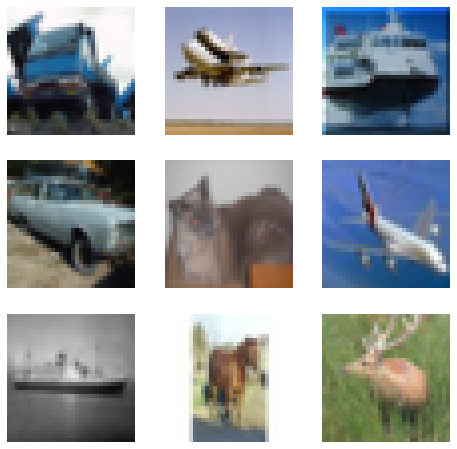

In [4]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    # plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [9]:
imgs = []
labels = []
for i in range(len(training_data)):
    img, label = data[i]
    imgs.append(img)
    labels.append(label)

print(max(labels),min(labels))
K = 10


9 0


## Forward Process

In [19]:
# simple CNN

class simpleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,32,3,2)
    self.conv2 = nn.Conv2d(32,64,3,2)
    self.conv3 = nn.Conv2d(64,128,3,2)
    self.dropout = nn.Dropout(0.2)
    self.flatten = nn.Flatten(1,-1)
    self.linear1 = nn.Linear(1152, 120)
    self.linear2 = nn.Linear(120, K)
    self.softmax = nn.Softmax(dim=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128)
    pass
  def forward(self, input):
    t = self.bn1(F.relu(self.conv1(input)))
    t = self.bn2(F.relu(self.conv2(t)))
    t = self.bn3(F.relu(self.conv3(t)))
    t = self.flatten(t)
    t = self.dropout(t)
    t = F.relu(self.linear1(t))
    t = self.dropout(t)
    t = self.softmax(self.linear2(t))
    return t

model = simpleCNN()
print(model)

simpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=1152, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [20]:
epochs = 50
lr = 0.001
bs = 100
min_valid_loss = np.inf
loss_func = torch.nn.CrossEntropyLoss()

train_dataloader = DataLoader(training_data, batch_size=bs, shuffle=True)
# eval_dataloader = DataLoader(val_data, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=True)
eval_dataloader = test_dataloader

def train_loop(epoch, min_valid_loss, loss_func, model, eval=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss = 0.0
    trainf1 = 0.0
    model.train()
    
    for i, data in tqdm(enumerate(train_dataloader)):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        target = model(inputs)
        preds = torch.argmax(target, dim=1)
        f1score = f1_score(labels.detach().numpy(), preds.detach().numpy(), average='weighted')
        labels = nn.functional.one_hot(labels, K)
        loss = loss_func(target.float(), labels.float())
        #loss = loss_func(target, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        trainf1 += np.sum(f1score)


    if eval==True:
        valid_loss = 0.0
        valf1 = 0.0
        model.eval()     # Optional when not using model Specific layer
        for i, data in enumerate(eval_dataloader):
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels =inputs.cuda(), labels.cuda()
            target = model(inputs)
            preds = torch.argmax(target, dim=1)
            f1score = f1_score(labels.detach().numpy(), preds.detach().numpy(), average='weighted')
            labels = nn.functional.one_hot(labels, K)
            loss = loss_func(target.float(), labels.float())
            valid_loss += loss.item() * len(inputs)
            valf1 += np.sum(f1score)
            if i == 20: break

        if epoch%1==0:
            print(f'Epoch {epoch+1} \t Training Loss: {train_loss, train_loss / len(train_dataloader)} \t Training F1 Score: {trainf1, trainf1 / len(train_dataloader)}')
            print(f'\t Validation Loss: {valid_loss, valid_loss / bs / 21}  \t Validation F1 Score: {valf1, valf1 / 21}')
        if min_valid_loss > valid_loss:
            print(f"Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f})")
            min_valid_loss = valid_loss
            # Saving State Dict
            torch.save(model.state_dict(), 'saved_model.pth')
    else:
        if epoch%1==0:
            print(f'Epoch {epoch+1} \t Training Loss: {train_loss, train_loss / len(train_dataloader)} \t Training F1 Score: {trainf1, trainf1 / len(train_dataloader)}')
    return min_valid_loss

In [21]:
for epoch in range(epochs):
    min_valid_loss = train_loop(epoch, min_valid_loss, loss_func, model, eval=True)

500it [00:45, 11.08it/s]


Epoch 1 	 Training Loss: (999.4306968450546, 1.9988613936901092) 	 Training F1 Score: (223.660598586214, 0.447321197172428)
	 Validation Loss: (4006.6503286361694, 1.9079287279219854)  	 Validation F1 Score: (11.398493003711984, 0.5427853811291421)
Validation Loss Decreased(inf--->4006.650329)


500it [00:43, 11.57it/s]


Epoch 2 	 Training Loss: (948.9465662240982, 1.8978931324481965) 	 Training F1 Score: (278.46723609255605, 0.556934472185112)
	 Validation Loss: (3919.5281505584717, 1.866441976456415)  	 Validation F1 Score: (12.38878538232527, 0.5899421610631082)
Validation Loss Decreased(4006.650329--->3919.528151)


500it [00:44, 11.35it/s]


Epoch 3 	 Training Loss: (929.4733011722565, 1.858946602344513) 	 Training F1 Score: (298.5843845034479, 0.5971687690068957)
	 Validation Loss: (3816.920566558838, 1.8175812221708751)  	 Validation F1 Score: (13.308674196208276, 0.6337463902956322)
Validation Loss Decreased(3919.528151--->3816.920567)


500it [00:44, 11.33it/s]


Epoch 4 	 Training Loss: (915.8671724796295, 1.8317343449592591) 	 Training F1 Score: (312.4784895241406, 0.6249569790482813)
	 Validation Loss: (3835.6041193008423, 1.8264781520480202)  	 Validation F1 Score: (13.207414324413708, 0.628924491638748)


500it [00:45, 11.01it/s]


Epoch 5 	 Training Loss: (907.4101848602295, 1.814820369720459) 	 Training F1 Score: (321.94575759895696, 0.6438915151979139)
	 Validation Loss: (3777.1108984947205, 1.7986242373784382)  	 Validation F1 Score: (13.750039012179874, 0.6547637624847559)
Validation Loss Decreased(3816.920567--->3777.110898)


500it [00:44, 11.12it/s]


Epoch 6 	 Training Loss: (902.9389185905457, 1.8058778371810913) 	 Training F1 Score: (325.8796051639923, 0.6517592103279847)
	 Validation Loss: (3750.6964683532715, 1.7860459373110817)  	 Validation F1 Score: (14.078567383896065, 0.6704079706617174)
Validation Loss Decreased(3777.110898--->3750.696468)


500it [00:43, 11.41it/s]


Epoch 7 	 Training Loss: (895.7180290222168, 1.7914360580444335) 	 Training F1 Score: (333.63831376870075, 0.6672766275374015)
	 Validation Loss: (3750.6242513656616, 1.7860115482693626)  	 Validation F1 Score: (14.330708195982893, 0.6824146759991854)
Validation Loss Decreased(3750.696468--->3750.624251)


500it [00:43, 11.51it/s]


Epoch 8 	 Training Loss: (891.095883846283, 1.7821917676925658) 	 Training F1 Score: (338.00826584283186, 0.6760165316856637)
	 Validation Loss: (3769.424557685852, 1.794964075088501)  	 Validation F1 Score: (13.969730917192582, 0.6652252817710753)


500it [00:44, 11.34it/s]


Epoch 9 	 Training Loss: (885.7004779577255, 1.771400955915451) 	 Training F1 Score: (343.91105502515336, 0.6878221100503067)
	 Validation Loss: (3724.7546315193176, 1.7736926816758656)  	 Validation F1 Score: (14.42790291275295, 0.6870429958453785)
Validation Loss Decreased(3750.624251--->3724.754632)


500it [00:46, 10.71it/s]


Epoch 10 	 Training Loss: (883.120945930481, 1.766241891860962) 	 Training F1 Score: (345.88747336832205, 0.6917749467366441)
	 Validation Loss: (3740.0086522102356, 1.780956501052493)  	 Validation F1 Score: (14.166430475891296, 0.674591927423395)


500it [00:44, 11.36it/s]


Epoch 11 	 Training Loss: (878.8768371343613, 1.7577536742687225) 	 Training F1 Score: (350.65157372371635, 0.7013031474474327)
	 Validation Loss: (3753.936195373535, 1.787588664463588)  	 Validation F1 Score: (14.074534277833838, 0.6702159179920875)


500it [00:44, 11.35it/s]


Epoch 12 	 Training Loss: (877.3883936405182, 1.7547767872810365) 	 Training F1 Score: (351.9062552584187, 0.7038125105168374)
	 Validation Loss: (3715.9903168678284, 1.7695191985084897)  	 Validation F1 Score: (14.40139735574366, 0.6857808264639838)
Validation Loss Decreased(3724.754632--->3715.990317)


500it [00:44, 11.32it/s]


Epoch 13 	 Training Loss: (875.1480684280396, 1.7502961368560792) 	 Training F1 Score: (354.7591943846107, 0.7095183887692214)
	 Validation Loss: (3674.8897433280945, 1.749947496822902)  	 Validation F1 Score: (14.919508960242947, 0.7104528076306165)
Validation Loss Decreased(3715.990317--->3674.889743)


500it [00:43, 11.39it/s]


Epoch 14 	 Training Loss: (873.3183377981186, 1.7466366755962373) 	 Training F1 Score: (356.96998522521494, 0.7139399704504299)
	 Validation Loss: (3652.568817138672, 1.7393184843517484)  	 Validation F1 Score: (15.066728974476876, 0.7174632844988988)
Validation Loss Decreased(3674.889743--->3652.568817)


500it [00:46, 10.82it/s]


Epoch 15 	 Training Loss: (871.458745598793, 1.742917491197586) 	 Training F1 Score: (358.59980266044096, 0.7171996053208819)
	 Validation Loss: (3669.722354412079, 1.7474868354343234)  	 Validation F1 Score: (14.984928417797112, 0.7135680198951005)


500it [00:43, 11.41it/s]


Epoch 16 	 Training Loss: (870.0978093147278, 1.7401956186294556) 	 Training F1 Score: (359.12206066115124, 0.7182441213223025)
	 Validation Loss: (3683.202874660492, 1.7539061307907104)  	 Validation F1 Score: (14.741182546214427, 0.7019610736292584)


500it [00:43, 11.46it/s]


Epoch 17 	 Training Loss: (866.8909047842026, 1.7337818095684052) 	 Training F1 Score: (362.85667271845915, 0.7257133454369183)
	 Validation Loss: (3692.5460934638977, 1.758355282601856)  	 Validation F1 Score: (14.71503107245978, 0.7007157653552276)


500it [00:44, 11.21it/s]


Epoch 18 	 Training Loss: (863.2977524995804, 1.7265955049991608) 	 Training F1 Score: (366.2274180200944, 0.7324548360401888)
	 Validation Loss: (3662.013900279999, 1.7438161429904757)  	 Validation F1 Score: (14.992134535232724, 0.7139111683444155)


500it [00:44, 11.31it/s]


Epoch 19 	 Training Loss: (863.9488306045532, 1.7278976612091064) 	 Training F1 Score: (365.67410519458963, 0.7313482103891793)
	 Validation Loss: (3675.4371881484985, 1.7502081848326183)  	 Validation F1 Score: (14.945270853626395, 0.7116795644583997)


500it [00:46, 10.75it/s]


Epoch 20 	 Training Loss: (862.5092943906784, 1.7250185887813567) 	 Training F1 Score: (367.31167220623894, 0.7346233444124779)
	 Validation Loss: (3706.298565864563, 1.7649040789831252)  	 Validation F1 Score: (14.462731939328267, 0.6887015209203936)


500it [00:44, 11.32it/s]


Epoch 21 	 Training Loss: (861.2943384647369, 1.7225886769294738) 	 Training F1 Score: (368.4670010854088, 0.7369340021708176)
	 Validation Loss: (3646.4526772499084, 1.7364060367856706)  	 Validation F1 Score: (15.11433562127378, 0.7197302676797038)
Validation Loss Decreased(3652.568817--->3646.452677)


500it [00:44, 11.25it/s]


Epoch 22 	 Training Loss: (859.4140462875366, 1.7188280925750732) 	 Training F1 Score: (370.4156600674558, 0.7408313201349116)
	 Validation Loss: (3652.7286767959595, 1.739394607998076)  	 Validation F1 Score: (15.10363094905611, 0.7192205213836242)


500it [00:44, 11.19it/s]


Epoch 23 	 Training Loss: (860.7267241477966, 1.7214534482955932) 	 Training F1 Score: (368.8349537036922, 0.7376699074073844)
	 Validation Loss: (3649.820828437805, 1.7380099183037168)  	 Validation F1 Score: (15.086376034791243, 0.718398858799583)


500it [00:44, 11.11it/s]


Epoch 24 	 Training Loss: (858.4329829216003, 1.7168659658432006) 	 Training F1 Score: (371.3022485978936, 0.7426044971957871)
	 Validation Loss: (3685.044026374817, 1.7547828697022938)  	 Validation F1 Score: (14.84928753786403, 0.7071089303744775)


500it [00:46, 10.73it/s]


Epoch 25 	 Training Loss: (855.5255718231201, 1.7110511436462403) 	 Training F1 Score: (374.17098554242324, 0.7483419710848465)
	 Validation Loss: (3662.5669598579407, 1.7440795046942574)  	 Validation F1 Score: (14.970680278503862, 0.7128895370716124)


500it [00:44, 11.22it/s]


Epoch 26 	 Training Loss: (854.7515988349915, 1.7095031976699828) 	 Training F1 Score: (375.146205136625, 0.75029241027325)
	 Validation Loss: (3686.530613899231, 1.7554907685234433)  	 Validation F1 Score: (14.754539365148077, 0.7025971126260989)


500it [00:44, 11.20it/s]


Epoch 27 	 Training Loss: (854.703102350235, 1.70940620470047) 	 Training F1 Score: (375.18108322115546, 0.7503621664423109)
	 Validation Loss: (3701.078140735626, 1.76241816225506)  	 Validation F1 Score: (14.590297810442078, 0.6947760862115275)


500it [00:44, 11.16it/s]


Epoch 28 	 Training Loss: (853.2826237678528, 1.7065652475357056) 	 Training F1 Score: (376.65479746592274, 0.7533095949318455)
	 Validation Loss: (3653.739035129547, 1.73987573101407)  	 Validation F1 Score: (15.078494442829978, 0.7180235448966656)


500it [00:44, 11.19it/s]


Epoch 29 	 Training Loss: (853.0677225589752, 1.7061354451179505) 	 Training F1 Score: (376.5240051398448, 0.7530480102796896)
	 Validation Loss: (3652.33393907547, 1.7392066376549857)  	 Validation F1 Score: (15.112831949992854, 0.719658664285374)


500it [00:46, 10.77it/s]


Epoch 30 	 Training Loss: (851.320679306984, 1.702641358613968) 	 Training F1 Score: (378.79989941004646, 0.7575997988200929)
	 Validation Loss: (3653.0526399612427, 1.7395488761720204)  	 Validation F1 Score: (15.034790389550704, 0.7159423995024145)


500it [00:45, 11.01it/s]


Epoch 31 	 Training Loss: (851.3907475471497, 1.7027814950942992) 	 Training F1 Score: (378.668928783403, 0.7573378575668059)
	 Validation Loss: (3670.2932119369507, 1.7477586723509289)  	 Validation F1 Score: (14.943449043798138, 0.7115928116094351)


500it [00:46, 10.74it/s]


Epoch 32 	 Training Loss: (849.6972695589066, 1.6993945391178131) 	 Training F1 Score: (380.37419738946227, 0.7607483947789245)
	 Validation Loss: (3664.228141307831, 1.7448705434799194)  	 Validation F1 Score: (14.92607508726692, 0.7107654803460438)


500it [00:45, 10.99it/s]


Epoch 33 	 Training Loss: (847.9650956392288, 1.6959301912784577) 	 Training F1 Score: (382.0904136167389, 0.7641808272334778)
	 Validation Loss: (3639.103865623474, 1.7329066026778448)  	 Validation F1 Score: (15.209158885852595, 0.7242456612310759)
Validation Loss Decreased(3646.452677--->3639.103866)


500it [00:47, 10.49it/s]


Epoch 34 	 Training Loss: (849.427142739296, 1.698854285478592) 	 Training F1 Score: (380.5062592695296, 0.7610125185390593)
	 Validation Loss: (3648.9473819732666, 1.7375939914158411)  	 Validation F1 Score: (15.241746999027804, 0.7257974761441811)


500it [00:45, 11.06it/s]
500it [00:45, 11.03it/s]


Epoch 36 	 Training Loss: (847.9036856889725, 1.695807371377945) 	 Training F1 Score: (382.25715100437867, 0.7645143020087574)
	 Validation Loss: (3656.0221791267395, 1.7409629424413045)  	 Validation F1 Score: (15.066030874119182, 0.7174300416247229)


500it [00:45, 10.93it/s]


Epoch 37 	 Training Loss: (845.5177363157272, 1.6910354726314545) 	 Training F1 Score: (384.4070189542601, 0.7688140379085202)
	 Validation Loss: (3643.2881593704224, 1.7348991235097249)  	 Validation F1 Score: (15.217697134561833, 0.7246522445029444)


500it [00:45, 10.95it/s]


Epoch 38 	 Training Loss: (846.1388515233994, 1.6922777030467988) 	 Training F1 Score: (384.06054650103505, 0.7681210930020701)
	 Validation Loss: (3681.696891784668, 1.7531889960879372)  	 Validation F1 Score: (14.793794313022593, 0.7044663958582187)


500it [00:46, 10.66it/s]


Epoch 39 	 Training Loss: (846.1461542844772, 1.6922923085689545) 	 Training F1 Score: (384.2426239694806, 0.7684852479389611)
	 Validation Loss: (3640.8761858940125, 1.7337505647114344)  	 Validation F1 Score: (15.178512696903887, 0.7227863189001851)


500it [00:45, 10.89it/s]


Epoch 40 	 Training Loss: (843.2369331121445, 1.6864738662242889) 	 Training F1 Score: (386.40318606540035, 0.7728063721308007)
	 Validation Loss: (3601.486015319824, 1.7149933406284876)  	 Validation F1 Score: (15.639283676607338, 0.7447277941241589)
Validation Loss Decreased(3629.044521--->3601.486015)


500it [00:45, 10.90it/s]


Epoch 41 	 Training Loss: (844.5614762306213, 1.6891229524612428) 	 Training F1 Score: (385.3533953865575, 0.770706790773115)
	 Validation Loss: (3648.7297534942627, 1.7374903588067918)  	 Validation F1 Score: (15.148594295042487, 0.7213616330972613)


500it [00:45, 10.94it/s]


Epoch 42 	 Training Loss: (844.0671489238739, 1.6881342978477478) 	 Training F1 Score: (386.0655081779086, 0.7721310163558173)
	 Validation Loss: (3604.281985759735, 1.7163247551236833)  	 Validation F1 Score: (15.544351810105658, 0.7402072290526504)


500it [00:46, 10.80it/s]


Epoch 43 	 Training Loss: (842.6560065746307, 1.6853120131492614) 	 Training F1 Score: (387.1412247622603, 0.7742824495245206)
	 Validation Loss: (3615.854334831238, 1.7218353975386846)  	 Validation F1 Score: (15.482535026916457, 0.7372635727103075)


500it [00:47, 10.48it/s]


Epoch 44 	 Training Loss: (842.7044891119003, 1.6854089782238006) 	 Training F1 Score: (387.5457114423088, 0.7750914228846176)
	 Validation Loss: (3619.5149064064026, 1.7235785268601918)  	 Validation F1 Score: (15.35551188110923, 0.7312148514813919)


500it [00:45, 10.94it/s]


Epoch 45 	 Training Loss: (841.6974339485168, 1.6833948678970336) 	 Training F1 Score: (388.54663394369595, 0.7770932678873919)
	 Validation Loss: (3595.2719926834106, 1.7120342822301955)  	 Validation F1 Score: (15.666049702378494, 0.7460023667799283)
Validation Loss Decreased(3601.486015--->3595.271993)


500it [00:45, 10.89it/s]


Epoch 46 	 Training Loss: (843.405931353569, 1.686811862707138) 	 Training F1 Score: (386.65780612883475, 0.7733156122576695)
	 Validation Loss: (3610.3070735931396, 1.7191938445681618)  	 Validation F1 Score: (15.519165322505506, 0.7390078725002622)


500it [00:46, 10.78it/s]


Epoch 47 	 Training Loss: (840.8049448728561, 1.6816098897457123) 	 Training F1 Score: (389.1481931908926, 0.7782963863817852)
	 Validation Loss: (3643.985092639923, 1.7352309964952015)  	 Validation F1 Score: (15.213193624063127, 0.7244377916220537)


500it [00:47, 10.60it/s]


Epoch 48 	 Training Loss: (840.1686342954636, 1.680337268590927) 	 Training F1 Score: (389.84428409132556, 0.7796885681826511)
	 Validation Loss: (3625.6637930870056, 1.7265065681366694)  	 Validation F1 Score: (15.340299799862006, 0.7304904666600955)


500it [00:46, 10.71it/s]


Epoch 49 	 Training Loss: (841.4839526414871, 1.6829679052829742) 	 Training F1 Score: (388.3775386334425, 0.776755077266885)
	 Validation Loss: (3613.2038474082947, 1.7205732606706166)  	 Validation F1 Score: (15.51062421534035, 0.7386011531114453)


500it [00:45, 10.96it/s]


Epoch 50 	 Training Loss: (840.9371184110641, 1.6818742368221282) 	 Training F1 Score: (388.9013911927471, 0.7778027823854942)
	 Validation Loss: (3637.2057676315308, 1.7320027464912051)  	 Validation F1 Score: (15.24000281977759, 0.7257144199894091)
